In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt
from tqdm import tqdm
from prettytable import PrettyTable

In [2]:
class Datasets:
    files = dict(
        IRIS = './iris.csv',
        MNIST = './mnist.csv',
        BANK_NOTE = './bank_note.csv',
        BREAST_CANCER = './breast_cancer.csv'
    )
    
    
    targets = dict(
        IRIS_TARGET = 'species_coded',
        MNIST_TARGET = 'label',
        BANK_NOTE_TARGET = 'class',
        BREAST_CANCER_TARGET = 'diagnosis_coded'
    )
    

In [113]:
def import_dataset(filename: str) -> pd.DataFrame:
    '''Import dataset specified by the filename.
    
    Format of the dataset should be '.csv'
    '''
    return pd.read_csv(filename, sep=',')

def normalize(dataset: pd.DataFrame)-> pd.DataFrame:
    scaler = MinMaxScaler()
    new_data = scaler.fit_transform(dataset)
    return pd.DataFrame(new_data, columns=dataset.columns)

def split(X, y):
    '''Perform train test split in ratio 80:20
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)
    return X_train, X_test, y_train, y_test

# def init_params(size, variance=1.0):
#     '''Initialize parameters (weights or bias) using normal distribution with mean=0
#     and variance=1.0
#     '''
#     return tf.Variable((tf.random.normal(size) * variance))

def rev_one_hot(one_hot_vec)-> int:
    new_vec = [tf.argmax(vec, axis=0).numpy() for vec in one_hot_vec]
    return new_vec

class NeuralNetwork:
    
    learning_rate = tf.constant([10e-4])
    
    def __init__(self):
        self.w1 = []
        self.b1 = []
        self.w2 = []
        self.b2 = []
        self.w3 = []
        self.k0  = 0
        self.k1  = 0
        self.class_type = 'binary'
    
    def _init_params(self, size, variance=1.0):
        '''Return a tensorflow variable with value from normal distribution with mean=0
        and variance=1.0 with corresponding size
        '''
        return tf.Variable((tf.random.normal(size) * variance))
    
    def _init_weights_and_bias(self, input_shape: int, output_neurons: int, hidden_1: int, hidden_2: int):
        '''Initialize weights and bias'''
        self.w1 = self._init_params((input_shape, hidden_1))
        self.b1 = self._init_params([1])
        
        self.w2 = self._init_params((hidden_1, hidden_2))
        self.b2 = self._init_params([1])
        
        self.w3 = self._init_params((hidden_2, output_neurons))
        self.k0 = self._init_params([1])
        self.k1 = self._init_params([1])
    
    def _activation_function(self, x):
        '''Custom activation function'''
        return self.k0 + self.k1*x
    
    def _build_model(self, X_train: pd.DataFrame, y_train: pd.Series, num_classes=2):
        '''Build a neural network with 1 hidden layer'''
        hidden_layer1_size: int = 2
        hidden_layer2_size: int = 2
        output_size = num_classes
        if num_classes <= 2:
            output_size = 1
        
        self._init_weights_and_bias(X_train.shape[1], output_size, hidden_layer1_size, hidden_layer2_size)
        
    def _forward_propagation(self, X_batch):
        l1 = tf.linalg.matmul(X_batch, self.w1) + self.b1
        a1 = self._activation_function(l1)
        
        l2 = tf.linalg.matmul(a1, self.w2) + self.b2
        a2 = self._activation_function(l2)
        
        l3 = tf.linalg.matmul(a2, self.w3)
        
        forwprop_vals = dict(
            l1 = l1,
            a1 = a1,
            l2 = l2,
            a2 = a2,
            l3 = l3
        )
        if self.class_type == 'binary':
            return tf.math.sigmoid(l3), forwprop_vals
        else:
            return tf.nn.softmax(l3), forwprop_vals
    
    def _loss_calc(self, loss: str, y_true, y_pred):
        if loss == 'binary_crossentropy':
            return tf.keras.losses.binary_crossentropy(y_true, y_pred)
        else:
            return tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        
    def _backward_propagation(self, tape, loss, forwardProp_eqns):
        dw1, db1, dw2, db2, dw3, da1, da2 = tape.gradient(loss, 
                                                [self.w1, self.b1, self.w2, self.b2, self.w3, 
                                                 forwardProp_eqns['a1'], forwardProp_eqns['a2']])
        
        dK = [
            tf.math.reduce_mean(da1) + tf.math.reduce_mean(da2),
            tf.math.reduce_mean(da1 * forwardProp_eqns['l1']) + tf.math.reduce_mean(da2 * forwardProp_eqns['l2'])
        ]
        
        return dict(
            grad_w1 = dw1, 
            grad_b1 = db1, 
            grad_w2 = dw2, 
            grad_b2 = db2, 
            grad_w3 = dw3,
            grad_K = dK
        )
    
    def _update_params(self, grads: dict):
        self.w1.assign_sub(grads['grad_w1'] * NeuralNetwork.learning_rate)
        self.b1.assign_sub(grads['grad_b1'] * NeuralNetwork.learning_rate)
        self.w2.assign_sub(grads['grad_w2'] * NeuralNetwork.learning_rate)
        self.b2.assign_sub(grads['grad_b2'] * NeuralNetwork.learning_rate)
        self.w3.assign_sub(grads['grad_w3'] * NeuralNetwork.learning_rate)
        self.k0.assign_sub(grads['grad_K'][0] * NeuralNetwork.learning_rate)
        self.k1.assign_sub(grads['grad_K'][1] * NeuralNetwork.learning_rate)
        
    def _batch_split(self, batch_size, iter_num, X_train: pd.DataFrame, y_train):
        rem = (iter_num+1)*batch_size
        if (iter_num+1)*batch_size > X_train.shape[0]:
            rem = X_train.shape[0]
        X_batch = X_train.iloc(axis=0)[iter_num*batch_size:rem]
        if type(y_train) == pd.Series:
            y_batch = y_train.iloc[iter_num*batch_size:rem]
            y_batch = np.reshape(y_batch.values, (y_batch.shape[0], 1))
        else:
            y_batch = y_train[iter_num*batch_size:rem]
        
        X_batch = X_batch.values.astype('float32')
        
        return X_batch, y_batch
        
    def fit(self, 
            X_train: pd.DataFrame, y_train, 
            X_test: pd.DataFrame, y_test,
            epochs: int = 100, class_type='binary', num_classes=2):
        
        self.class_type = class_type
        
        batch_size = 50
        
        if self.class_type != 'binary':
            loss_type = 'categorical_crossentropy'
        else:
            loss_type = 'binary_crossentropy'
        
        # Build the model
        self._build_model(X_train, y_train, num_classes=num_classes)
        
        train_losses = []
        test_losses = []
        
        for i in tqdm(range(epochs)):
            with tf.GradientTape(persistent=True) as tape:
                for j in range(X_train.shape[0] // batch_size):
                    X_batch, y_batch = self._batch_split(batch_size, j, X_train, y_train)
                    
                    # Forward prop
                    predictions, forwardProp_eqns = self._forward_propagation(X_batch)
#                     print(y_batch, predictions)
                    #Loss Calculation
                    loss = self._loss_calc(loss_type, y_batch, predictions)
#                     print(loss)
                    # Backward Prop
                    gradients = self._backward_propagation(tape, loss, forwardProp_eqns)

                    # Parameter update
                    self._update_params(gradients)
                test_pred, _ = self._forward_propagation(X_test.values.astype('float32'))
                test_loss = self._loss_calc(loss_type, y_test, test_pred)
                    
            train_losses.append(np.sum(loss.numpy()))
            test_losses.append(np.sum(test_loss.numpy()))
                
        return train_losses, test_losses
        
    def predict(self, X_test: pd.DataFrame):
        X_test = X_test.values.astype('float32')
        predictions, _ = self._forward_propagation(X_test)
        return predictions
    
    def metric_accuracy(self, y_true, y_pred):
        if self.class_type != 'binary':
            y_true = rev_one_hot(y_true)
            y_pred = rev_one_hot(y_pred)
        else:
            y_pred = np.where(y_pred > 0.7, 1, 0)
            
        return accuracy_score(y_true, y_pred)
    
    def metric_f1(self, y_true, y_pred):
        if self.class_type != 'binary':
            y_true = rev_one_hot(y_true)
            y_pred = rev_one_hot(y_pred)
        else:
            y_pred = np.where(y_pred > 0.7, 1, 0)
            
        return f1_score(y_true, y_pred, average='weighted')

In [120]:
data = import_dataset(Datasets.files['BREAST_CANCER'])
X_cols = [col for col in data.columns if col != Datasets.targets['BREAST_CANCER_TARGET']]
y_col = Datasets.targets['BREAST_CANCER_TARGET']

X, y = data[X_cols], data[y_col]
num_labels = len(y.unique())
if len(y.unique()) > 2:
    y = tf.one_hot(tf.constant(y.values, tf.int32), depth=len(y.unique())).numpy()

X_train, X_test, y_train, y_test = split(X, y)

X_train, X_test = normalize(X_train), normalize(X_test)

In [133]:
neuralNet = NeuralNetwork()
train_loss, test_loss = neuralNet.fit(X_train, y_train, X_test, y_test, epochs=50, class_type='binary', num_classes=num_labels)
print("Training Completed!!")

100%|██████████| 50/50 [00:03<00:00, 15.23it/s]

Training Completed!!


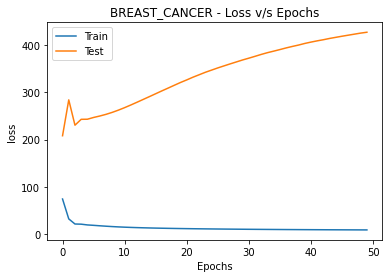

In [134]:
plt.plot(list(range(len(train_loss))), train_loss, label='Train')
plt.plot(list(range(len(test_loss))), test_loss, label='Test')
plt.ylabel('loss')
plt.title('BREAST_CANCER - Loss v/s Epochs')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [135]:
print(neuralNet.k0.numpy(), neuralNet.k1.numpy())

[-1.176416] [1.4020073]


In [136]:
table = PrettyTable()
table.field_names = ['Metric', 'Train', 'Test']

# Test Results
predictions = neuralNet.predict(X_test)
accuracy_train = neuralNet.metric_accuracy(y_test, predictions)
f1_train = neuralNet.metric_f1(y_test, predictions)

# Train Results
predictions = neuralNet.predict(X_train)
accuracy_test = neuralNet.metric_accuracy(y_train, predictions)
f1_test = neuralNet.metric_f1(y_train, predictions)

table.add_row(["Accuracy", accuracy_train, accuracy_test])
table.add_row(["F1-Score", f1_train, f1_test])
table.add_row(["Loss", train_loss[-1], test_loss[-1]])
print(table)

+----------+--------------------+--------------------+
|  Metric  |       Train        |        Test        |
+----------+--------------------+--------------------+
| Accuracy | 0.8771929824561403 | 0.9714285714285714 |
| F1-Score | 0.8792862838915472 |  0.97137619321347  |
|   Loss   |      8.55237       |      427.6549      |
+----------+--------------------+--------------------+
